In [76]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from itertools import permutations
import healpy as hp

from scipy import interpolate
from scipy.interpolate import SmoothSphereBivariateSpline
import scipy.fft as fft

from image_code import image_calculation_functions as ic

#from astropy.coordinates.tests.utils import randomly_sample_sphere
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
theta_p = 181
phi_p = 361
phi = np.linspace(-180,180,phi_p)*np.pi/180
theta = np.linspace(0,90,int(theta_p/2)+1)*np.pi/180
P,T = np.meshgrid(phi,theta)



In [78]:
ra_list,dec_list,flux_0p6,flux_2,flux_10 = np.loadtxt('/data4/nmahesh/edges/Lunar/catalog/GLEAM_Scut-1Jyto28kJy-3freqs.txt',skiprows=1,usecols=(1,2,3,4,5),unpack=True)

In [79]:
far_array=np.load('/data4/nmahesh/edges/Lunar/array_layout/farside_array_nooffset.npy')
far_array_off=np.load('/data4/nmahesh/edges/Lunar/array_layout/farside_array_offset.npy')

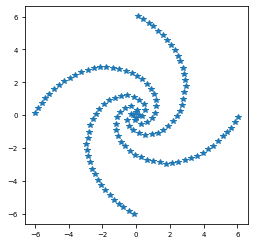

In [80]:
plt.figure(figsize=(4,4))
plt.plot(far_array[:,0],far_array[:,1],'*')

In [81]:

beam_squarel,ethetal, ephil=ic.read_feko('/data4/nmahesh/edges/Lunar/beam_files/dipole_0p1-1MHz_regolith-0',31,theta_p,phi_p)
beam_squarel90,ethetal90,ephil90=ic.read_feko('/data4/nmahesh/edges/Lunar/beam_files/dipole_0p1-1MHz_regolith-90',31,theta_p,phi_p)

beam_squareh,ethetah, ephih = ic.read_feko('/data4/nmahesh/edges/Lunar/beam_files/dipole_0p4-40MHz_regolith',10,theta_p,phi_p)
beam_squareh90,ethetah90,ephih90 = ic.read_feko('/data4/nmahesh/edges/Lunar/beam_files/dipole_0p4-40MHz_regolith-90',10,theta_p,phi_p)


In [82]:

sample = 1

if sample==0:
    wav = 500 #in m; f = 0.6 MHz
    index = 17
    beam_square,etheta, ephi = beam_squarel,ethetal, ephil
    beam_square90,etheta90,ephi90 = beam_squarel90,ethetal90,ephil90
    flux_list = flux_0p6
    factor =150
    
elif sample==1:
    wav = 150 # in m; f = 2MHz
    index = 3
    beam_square,etheta, ephi = beam_squareh,ethetah, ephih
    beam_square90,etheta90,ephi90=beam_squareh90,ethetah90,ephih90
    flux_list = flux_2
    factor =500

elif sample==2:
    wav = 30 # in m; f = 10MHz
    index = 4
    beam_square,etheta, ephi = beam_squareh,ethetah, ephih
    beam_square90,etheta90,ephi90=beam_squareh90,ethetah90,ephih90
    flux_list = flux_10
    factor =2500
    
f = 300/wav
####Normalizing by 2 MHz
l_grid = np.linspace(-1,1,int(factor))
m_grid = l_grid
L,M = np.meshgrid(l_grid,m_grid)

q = L**2+M**2
el = np.sqrt(1 - q)
el[q>=1] = 0
p =-np.arctan2(M,L) 
t = np.pi/2 - np.arcsin(el)#-np.arcsin(L,(np.sin(p)))+np.pi/2

etheta = np.roll(etheta[:,:,:-1],180,axis=2)/np.max(etheta[index,:,:])
etheta90 = np.roll(etheta90[:,:,:-1],180,axis=2)/np.max(etheta90[index,:,:])
ephi = np.roll(ephi[:,:,:-1],180,axis=2)/np.max(ephi[index,:,:])
ephi90 = np.roll(ephi90[:,:,:-1],180,axis=2)/np.max(ephi90[index,:,:])


ra_list_c = ra_list
dec_list_c = dec_list
flux_list_c = flux_list

<ipython-input-82-6994aa971919>:34: RuntimeWarning: invalid value encountered in sqrt
  el = np.sqrt(1 - q)


In [83]:
etheta[index,0,:]=0
etheta90[index,0,:]=0
ephi[index,0,:]=0
ephi90[index,0,:]=0

In [84]:
beam_etheta = ic.beam_interpolate(etheta[index],theta,phi[:-1],t,p)
beam_etheta90 = ic.beam_interpolate(etheta90[index],theta,phi[:-1],t,p)

beam_ephi = ic.beam_interpolate(ephi[index],theta,phi[:-1],t,p)
beam_ephi90 = ic.beam_interpolate(ephi90[index],theta,phi[:-1],t,p)



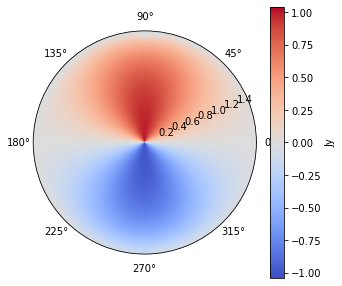

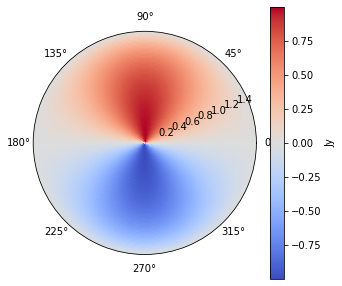

In [10]:
fig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(5,5))
p1 =ax.pcolormesh(p,t,np.real(beam_ephi),cmap='coolwarm')#vmin=-10, vmax =1000)
plt.colorbar(p1, ax=ax,label='Jy')


fig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(5,5))
p1 =ax.pcolormesh(P,T,np.real(ephi[index,:91]),cmap='coolwarm')#vmin=-10, vmax =1000)
plt.colorbar(p1, ax=ax,label='Jy')

Text(0.5, 0, 'Theta (rad)')

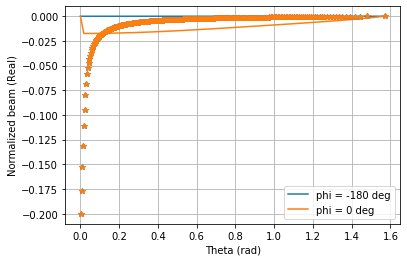

In [16]:
plt.plot(theta[:91],np.real(ephi[index,:91,0]),label='phi = -180 deg')
plt.plot(theta[:91],np.real(ephi[index,:91,179]), label='phi = 0 deg')

plt.plot(t[249, 250:],np.real(beam_ephi[250, 250:]),'*',color=colors[0])
plt.plot(t[249, 249::-1],np.real(beam_ephi[250, 249::-1]),'*',color = colors[1])
plt.legend()
plt.grid()
plt.ylabel('Normalized beam (Real)')
plt.xlabel('Theta (rad)')
#plt.title('phi= 90 & 270 cut')
#plt.ylim([-0.02,0.02])

Text(0.5, 0, 'Theta (rad)')

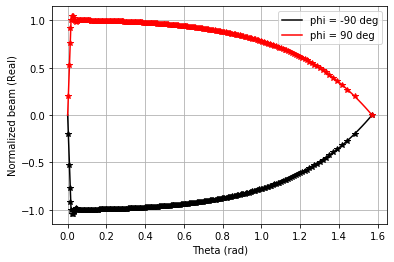

In [17]:
plt.plot(theta[:91],np.real(ephi[index,:91,90]),'k',label='phi = -90 deg')
plt.plot(theta[:91],np.real(ephi[index,:91,270]),'r', label='phi = 90 deg')


plt.plot(t[250:,249],np.real(beam_ephi[250:,249]),'k*')
plt.plot(t[249::-1,249],np.real(beam_ephi[249::-1,249]),'r*')
plt.legend()
plt.grid()
plt.ylabel('Normalized beam (Real)')
plt.xlabel('Theta (rad)')
#plt.xlim([0,np.pi/2])

In [85]:
off = np.linspace(-12,12,24)*u.hour
cyg_a_altaz = np.zeros((len(off),2))
cyg_A = ic.processed_source()



for i in range(len(off)):
    cyg_A.init_skycoord('19 59 28.35645829 +40 44 02.0966496', Time.now()+off[i])
    cyg_a_altaz[i] = cyg_A.obj_a_altaz
    
time = Time.now()+off[15]
t2 = Time(time, scale='utc',location=('180d', '0d'))
lst = t2.sidereal_time('apparent').value
print(t2,lst)

2022-04-30 08:23:33.067132 10.94335461584955


In [86]:
sky_obj = ic.processed_source()
sky_obj.init_skycoords(ra_list_c,dec_list_c,flux_list_c,time)

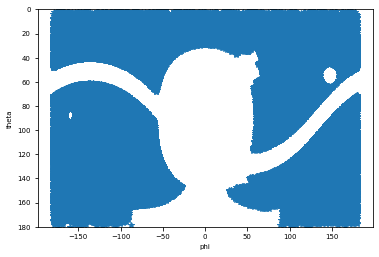

In [87]:
sky_obj.plot_skymap()

In [88]:
sky_obj.tp_to_lm(30,l_grid,m_grid)

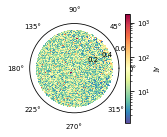

In [111]:

fig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(2,2))
p1 =ax.pcolormesh(p,t,sky_obj.sky_map,cmap='Spectral_r',norm= LogNorm())#vmin=-10, vmax =1000)
ax.set_ylim([0,35*np.pi/180])
plt.colorbar(p1, ax=ax,label='Jy')
plt.savefig('/data4/nmahesh/edges/Lunar/plots/gleam_sky_lm_30deg.pdf',bbox_inches='tight')#,dpi=200)

In [91]:
sky_obj.calculate_delphi(50,wav,L,M)

In [201]:
J = np.array([[beam_etheta,beam_ephi] ,[beam_etheta90,beam_ephi90]])

In [202]:
sky_obj.make_sky_coherence()
sky_obj.make_offset_jacob(J)

In [205]:
sky_obj.make_pseudo_vis(J)
sky_obj.invert_offset_jacob()


In [206]:
vis_temp_back = np.zeros_like(sky_obj.J_off,dtype=np.complex128)
vis_back = np.zeros_like(sky_obj.J_off,dtype=np.complex128)
for a in range(2):
    for b in range(2):

        #vis_temp[a,b]= np.sum(sky_obj.J_in[a,:] * self.sky_coherence[:,b],axis=0)
        vis_temp_back[a,b]= np.sum(sky_obj.J_in[a,:] * sky_obj.vis_off[:,b],axis=0)
       
for a in range(2):
    for b in range(2):

        #self.vis[a,b]= np.sum(vis_temp[a,:] * np.conj(J[b,:]),axis=0)
        vis_back[a,b]= np.sum(vis_temp_back[a,:] * np.conj(sky_obj.J_in[b,:]),axis=0)
       

(0, 0.6108652381980153)

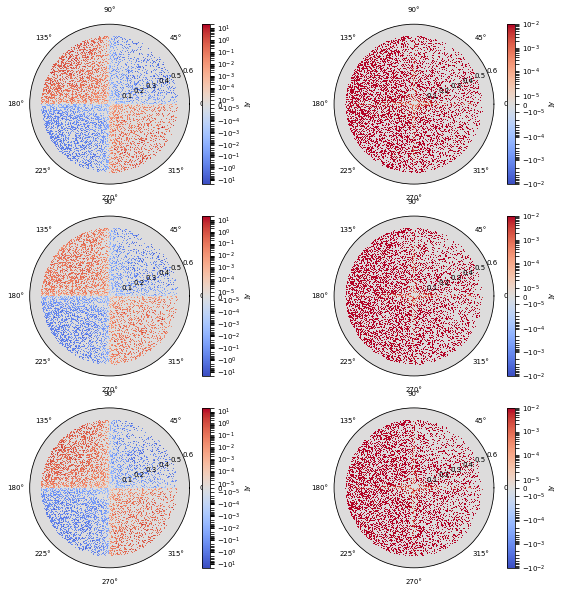

In [210]:
fig,ax = plt.subplots(3,2, subplot_kw=dict(polar=True),figsize=(10,10))
p1 =ax[0,0].pcolormesh(p,t,np.real(sky_obj.vis[1,0]),cmap='coolwarm',norm=SymLogNorm(linthresh=2e-5,vmin=-20, vmax =20))
plt.colorbar(p1, ax=ax[0,0],label='Jy')
ax[0,0].set_ylim([0,35*np.pi/180])

p1 =ax[0,1].pcolormesh(p,t,np.abs(sky_obj.vis[1,0]),cmap='coolwarm',norm=SymLogNorm(linthresh=2e-5,vmin=-1e-2, vmax =1e-2))
plt.colorbar(p1, ax=ax[0,1],label='Jy')
ax[0,1].set_ylim([0,35*np.pi/180])

p1 =ax[1,0].pcolormesh(p,t,np.real(sky_obj.vis_off[1,0]),cmap='coolwarm',norm=SymLogNorm(linthresh=2e-5, vmin=-20, vmax =20))
plt.colorbar(p1, ax=ax[1,0],label='Jy')
ax[1,0].set_ylim([0,35*np.pi/180])

p1 =ax[1,1].pcolormesh(p,t,np.abs(sky_obj.vis_off[1,0]),cmap='coolwarm',norm=SymLogNorm(linthresh=2e-5,vmin=-1e-2, vmax =1e-2))
plt.colorbar(p1, ax=ax[1,1],label='Jy')

ax[1,1].set_ylim([0,35*np.pi/180])

p1 =ax[2,0].pcolormesh(p,t,np.real(vis_back[1,0]),cmap='coolwarm',norm=SymLogNorm(linthresh=2e-5,vmin=-20, vmax =20))
plt.colorbar(p1, ax=ax[2,0],label='Jy')
ax[2,0].set_ylim([0,35*np.pi/180])

p1 =ax[2,1].pcolormesh(p,t,np.abs(vis_back[1,0]),cmap='coolwarm',norm=SymLogNorm(linthresh=2e-5,vmin=-1e-2, vmax =1e-2))
plt.colorbar(p1, ax=ax[2,1],label='Jy')
ax[2,1].set_ylim([0,35*np.pi/180])

In [103]:
beam_ft = sky_obj.fourier_vis_muller(vis=vis)
beam_ft_off = sky_obj.fourier_vis_muller(vis=vis_off)

In [106]:
sky_obj.uvcal(wav,far_array)

In [181]:
del_u,del_v,del_w = ic.uvcal(0,0,wav,50,50)
M_in = np.zeros((4,4, len(theta), len(phi)),dtype='complex')
for i in range(len(theta)):
    for j in range(len(phi)):


        l = np.sin(theta[i])*np.cos(phi[j])
        m = np.sin(theta[i]) * np.sin(phi[j])                             
        del_phi = 2*np.pi* (del_u*l + del_v*m)
        J = np.array([[1,0],[0,np.exp(1j*del_phi)]])

        M_in[:,:,i,j] = 0.5 * np.dot(np.array([[1,0,0,1],[1,0,0,-1],[0,1,1,0],[0,-1j,1j,0]]) , np.kron(J,np.conj(J))).dot(np.array([[1,1,0,0],[0,0,1,1j],[0,0,1,-1j],[1,-1,0,0]]))


In [182]:
M_in_lm = np.zeros((4,4,factor,factor))
for i in range(len(M_in_lm[:,0,0,0])):
    for j in range(len(M_in_lm[0,:,0,0])):
        M_in_lm[i,j,:,:] = ic.beam_interpolate(M_in[i,j,:91,:360],theta,phi[:-1],t,p)
    

<ipython-input-182-26278ad48a43>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  M_in_lm[i,j,:,:] = ic.beam_interpolate(M_in[i,j,:91,:360],theta,phi[:-1],t,p)


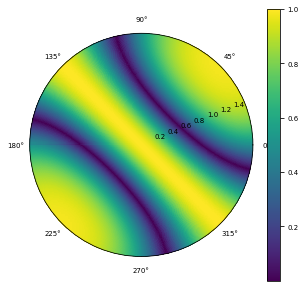

In [183]:
ig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(5,5))
plt.pcolormesh(p,t,np.abs(M_in_lm[3,3]));
plt.colorbar()

In [193]:
x = np.linspace(-60,60,128)
y = x.T
b = np.repeat(x[:, np.newaxis], 128, axis=1)
c = np.repeat(y[np.newaxis, :], 128, axis=0)
sky_obj.u = b.flatten()
sky_obj.v = c.flatten()

Text(0.5, 0, 'u-plane')

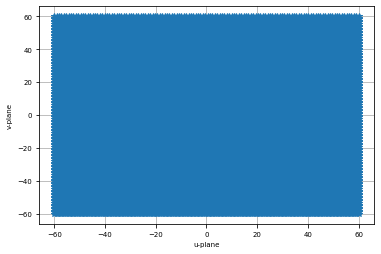

In [194]:
plt.plot(sky_obj.u,sky_obj.v,'*')
plt.grid()
plt.ylabel('v-plane')
plt.xlabel('u-plane')

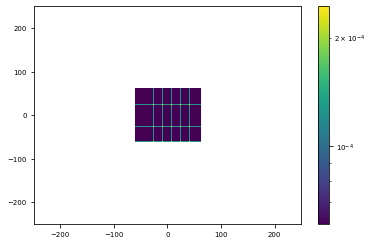

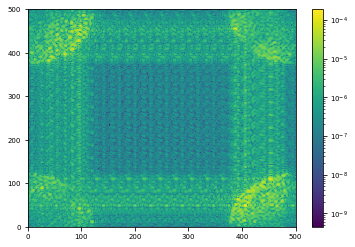

In [197]:
plt.pcolormesh(xedges,yedges,H,norm=LogNorm())
plt.colorbar()
plt.figure()
plt.pcolormesh(np.abs(fft.ifft2((H*beam_ft_off[3]))),norm=LogNorm())
plt.colorbar()

In [198]:
image_in = np.zeros_like(image,dtype=np.complex256)
for i in range(factor):
    for j in range(factor):
        image_in[:,i,j] = np.dot(np.linalg.inv(M_in_lm[:,:,i,j]),image_off[:,i,j])

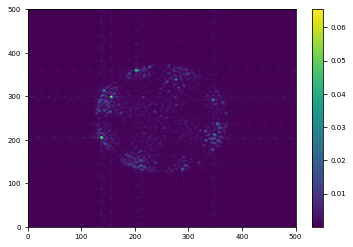

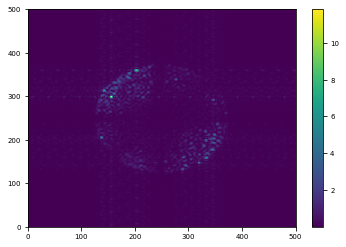

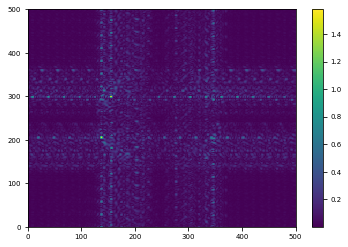

In [199]:
plt.pcolormesh(np.abs(image[3]))
plt.colorbar()

plt.figure()
plt.pcolormesh(np.abs(image_off[3]))
plt.colorbar()

plt.figure()
plt.pcolormesh(np.abs(image_in[3]))
plt.colorbar()

In [101]:

beam_check = (fft.fftshift(fft.fft2(fft.fftshift(vis[0].T))))

In [196]:
off_c=0
factor = int(np.shape(sky_obj.del_phi)[0])
H, xedges, yedges = np.histogram2d((sky_obj.u.flatten()),(sky_obj.v.flatten()),bins=(factor,factor),normed = True,range=[[-factor/2,factor/2],[-factor/2,factor/2]])
image = np.zeros_like(beam_ft,dtype = np.complex128) 
image_off = np.zeros_like(beam_ft,dtype = np.complex128)
vis = np.zeros_like(beam_ft, dtype = np.complex128)
vis_off = np.zeros_like(beam_ft, dtype = np.complex128)

for i in range(4):
    
        vis[i] =    H*beam_ft[i]
        vis_off[i] = H*beam_ft_off[i]

if off_c ==1:
    vis_offc = offset_correction(self.J_in_ft, vis_off)
elif off_c==2:
    vis_offc = offset_correction(self.J_in, vis_off)
else:
    vis_offc = vis_off

for i in range(4):
        image[i] = (fft.ifftshift(fft.ifft2(fft.ifftshift(vis[i]))))*(factor/2)**2
        image_off[i] = (fft.ifftshift(fft.ifft2(fft.ifftshift(vis_offc[i]))))*(factor/2)**2


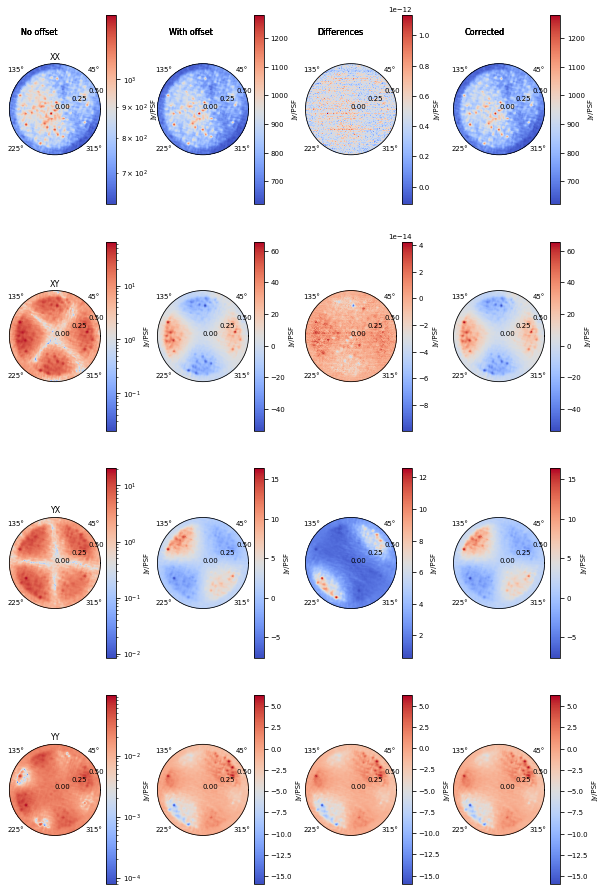

In [122]:
final = image
final_off = image_off
fig,ax = plt.subplots(4,4, subplot_kw=dict(polar=True),figsize=(10,16))
plt.subplots_adjust(wspace=0.3,hspace=0.2)
text = ['XX','XY','YX','YY']
plt.rc('font',size=7)
plt.rc('axes', labelsize=7)
           
for i in range(4):
           
    #fig.suptitle('Dipole beam on regolith @ '+ str(f)+'MHz',fontsize=18,y=0.95)  
    
    p1 =ax[int(i%4),0].pcolormesh(p,t,np.abs(final[i]),cmap='coolwarm',norm=LogNorm())    #,vmin=0, vmax = 0.0005)  
    plt.colorbar(p1, ax=ax[int(i%4),0],label='Jy/PSF')
    ax[int(i%4),0].set_title(text[i], pad=0.0, fontsize = 8)
    ax[int(i%4),0].set_rticks([0,0.25,0.5])
    ax[int(i%4),0].set_rlabel_position(25)
    ax[int(i%4),0].set_ylim([0,35*np.pi/180])
    ax[int(i%4),0].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax[int(i%4),0].tick_params(axis='x',pad=-0.5)
    ax[0,0].text(2,1.1,'No offset', fontsize=8)
    
    p1 =ax[int(i%4),1].pcolormesh(p,t,np.real(final_off[i]),cmap='coolwarm')    #,vmin=0, vmax = 0.0005)  
    plt.colorbar(p1, ax=ax[int(i%4),1],label='Jy/PSF')
    ax[int(i%4),1].set_rticks([0,0.25,0.5])
    ax[int(i%4),1].set_rlabel_position(25)
    ax[int(i%4),1].set_ylim([0,35*np.pi/180])
    ax[int(i%4),1].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax[int(i%4),1].tick_params(axis='x',pad=-0.5)
    ax[0,1].text(2,1.1,'With offset', fontsize=8)
    
    p1 =ax[int(i%4),3].pcolormesh(p,t,(np.real(final_off[i])),cmap='coolwarm')#,vmin=-1, vmax = 1)  
    plt.colorbar(p1, ax=ax[int(i%4),3],label='Jy/PSF')
    ax[int(i%4),3].set_rticks([0,0.25,0.5])
    ax[int(i%4),3].set_rlabel_position(25)
    ax[int(i%4),3].set_ylim([0, 35*np.pi/180])
    ax[int(i%4),3].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax[int(i%4),3].tick_params(axis='x',pad=-0.5)
    ax[0,3].text(2,1.1,'Corrected', fontsize=8)
    
    
    p1 =ax[int(i%4),2].pcolormesh(p,t,(np.real(final_off[i])- np.real(final[i])),cmap='coolwarm')#,vmin=-1, vmax = 1)  
    plt.colorbar(p1, ax=ax[int(i%4),2],label='Jy/PSF')
    ax[int(i%4),2].set_rticks([0,0.25,0.5])
    ax[int(i%4),2].set_rlabel_position(25)
    ax[int(i%4),2].set_ylim([0, 35*np.pi/180])
    ax[int(i%4),2].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax[int(i%4),2].tick_params(axis='x',pad=-0.5)
    ax[0,2].text(2,1.1,'Differences', fontsize=8)
    
#plt.savefig('/data4/nmahesh/edges/Lunar/plot_stokes_image_XX-YX_GLEAM_off_nooff_2mhz_real.png',dpi=200,bbox_inches='tight')




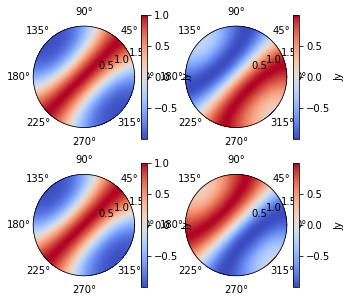

In [22]:
fig,ax = plt.subplots(2,2, subplot_kw=dict(polar=True),figsize=(5,5))
p1 =ax[0,0].pcolormesh(p,t,np.real(sky_obj.J_b[1,1]),cmap='coolwarm')
plt.colorbar(p1, ax=ax[0,0],label='Jy')

p1 =ax[0,1].pcolormesh(p,t,np.imag(sky_obj.J_b[1,1]),cmap='coolwarm')
plt.colorbar(p1, ax=ax[0,1],label='Jy')


p1 =ax[1,0].pcolormesh(p,t,np.real(sky_obj.J_in[1,1]),cmap='coolwarm')
plt.colorbar(p1, ax=ax[1,0],label='Jy')

p1 =ax[1,1].pcolormesh(p,t,np.imag(sky_obj.J_in[1,1]),cmap='coolwarm')
plt.colorbar(p1, ax=ax[1,1],label='Jy')

In [43]:
sky_obj.make_dirty_image(off_c=0)
corrected=ic.offset_correction(sky_obj.J_in,sky_obj.image_off)

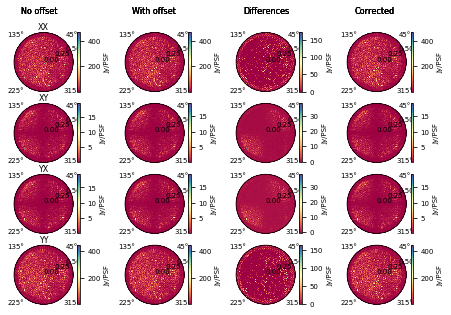

In [44]:

final = np.zeros((4,np.shape(sky_obj.beam_ft)[2],np.shape(sky_obj.beam_ft)[3]),dtype = np.complex128)
final_off = np.zeros((4,np.shape(sky_obj.beam_ft)[2],np.shape(sky_obj.beam_ft)[3]),dtype = np.complex128)
final_offc = np.zeros((4,np.shape(sky_obj.beam_ft)[2],np.shape(sky_obj.beam_ft)[3]),dtype = np.complex128)

c=0
for i in range(2):
    for j in range(2):
        final[c] = sky_obj.image[i,j] 
        final_off[c] = sky_obj.image_off[i,j]
        final_offc[c] = corrected[i,j]
        c=c+1
        
fig,ax = plt.subplots(4,4, subplot_kw=dict(polar=True),figsize=(7.5,5))
plt.subplots_adjust(wspace=0.3,hspace=0.2)
text = ['XX','XY','YX','YY']
plt.rc('font',size=7)
plt.rc('axes', labelsize=7)
           
for i in range(4):
           
    #fig.suptitle('Dipole beam on regolith @ '+ str(f)+'MHz',fontsize=18,y=0.95)  
    
    p1 =ax[int(i%4),0].pcolormesh(p,t,np.abs(final[i]),cmap='Spectral')#,norm=LogNorm())    #,vmin=0, vmax = 0.0005)  
    plt.colorbar(p1, ax=ax[int(i%4),0],label='Jy/PSF')
    ax[int(i%4),0].set_title(text[i], pad=0.0, fontsize = 8)
    ax[int(i%4),0].set_rticks([0,0.25,0.5])
    ax[int(i%4),0].set_rlabel_position(25)
    ax[int(i%4),0].set_ylim([0,35*np.pi/180])
    ax[int(i%4),0].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax[int(i%4),0].tick_params(axis='x',pad=-0.5)
    ax[0,0].text(2,1.1,'No offset', fontsize=8)
    
    p1 =ax[int(i%4),1].pcolormesh(p,t,np.abs(final_off[i]),cmap='Spectral')    #,vmin=0, vmax = 0.0005)  
    plt.colorbar(p1, ax=ax[int(i%4),1],label='Jy/PSF')
    ax[int(i%4),1].set_rticks([0,0.25,0.5])
    ax[int(i%4),1].set_rlabel_position(25)
    ax[int(i%4),1].set_ylim([0,35*np.pi/180])
    ax[int(i%4),1].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax[int(i%4),1].tick_params(axis='x',pad=-0.5)
    ax[0,1].text(2,1.1,'With offset', fontsize=8)
    
    p1 =ax[int(i%4),3].pcolormesh(p,t,(np.abs(final_offc[i])),cmap='Spectral')#,vmin=-1, vmax = 1)  
    plt.colorbar(p1, ax=ax[int(i%4),3],label='Jy/PSF')
    ax[int(i%4),3].set_rticks([0,0.25,0.5])
    ax[int(i%4),3].set_rlabel_position(25)
    ax[int(i%4),3].set_ylim([0, 35*np.pi/180])
    ax[int(i%4),3].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax[int(i%4),3].tick_params(axis='x',pad=-0.5)
    ax[0,3].text(2,1.1,'Corrected', fontsize=8)
    
    
    p1 =ax[int(i%4),2].pcolormesh(p,t,(np.abs(final_off[i])- np.real(final[i])),cmap='Spectral')#,vmin=-1, vmax = 1)  
    plt.colorbar(p1, ax=ax[int(i%4),2],label='Jy/PSF')
    ax[int(i%4),2].set_rticks([0,0.25,0.5])
    ax[int(i%4),2].set_rlabel_position(25)
    ax[int(i%4),2].set_ylim([0, 35*np.pi/180])
    ax[int(i%4),2].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax[int(i%4),2].tick_params(axis='x',pad=-0.5)
    ax[0,2].text(2,1.1,'Differences', fontsize=8)
    
#plt.savefig('/data4/nmahesh/edges/Lunar/plot_stokes_image_XX-YX_GLEAM_off_nooff_2mhz_real.png',dpi=200,bbox_inches='tight')




In [45]:
sky_pol = ic.beamtopol((final))
sky_pol_off = ic.beamtopol((final_off))
sky_pol_offc = ic.beamtopol((final_offc))
sky_pol_m = sky_pol[0],sky_pol[3]
sky_pol_off_m = sky_pol_off[0],sky_pol_off[3]
sky_pol_off_mc = sky_pol_offc[0],sky_pol_offc[3]

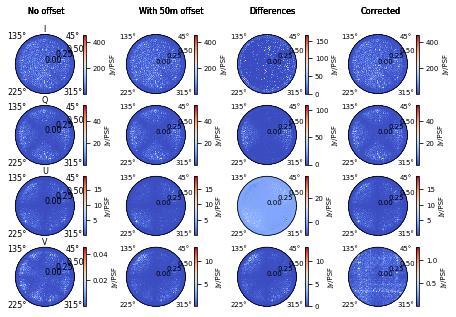

In [47]:

text = ['I', 'Q', 'U', 'V']
plt_no = 4
#ext = ['I','V']
fig2,ax2 = plt.subplots(plt_no,4, subplot_kw=dict(polar=True),figsize=(7.5,5))
plt.subplots_adjust(wspace=0.3,hspace=0.2)

#fig2.suptitle('Dipole beam on regolith @ '+ str(f)+'MHz',fontsize=14,y=1)

for i in range(plt_no):
    if i ==3:
        p2 = ax2[int(i%plt_no),0].pcolormesh(p,t,np.abs(sky_pol[i]),cmap='coolwarm')#,vmin=-0.1,vmax=0.1)
    else:
        p2 = ax2[int(i%plt_no),0].pcolormesh(p,t,np.abs(sky_pol[i]),cmap='coolwarm')#,vmin=vmin, vmax = vmax)#,norm=LogNorm())#,)  
    cbar = plt.colorbar(p2, ax=ax2[int(i%plt_no),0],label='Jy/PSF',pad=0.1)
    ax2[int(i%plt_no),0].set_rticks([0,0.25,0.5])
    ax2[int(i%plt_no),0].tick_params(axis='both', labelsize=8)
    ax2[int(i%plt_no),0].set_ylim([0,35*np.pi/180])
    ax2[int(i%plt_no),0].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax2[int(i%plt_no),0].tick_params(axis='x',pad=-0.5)
    ax2[int(i%plt_no),0].set_title(text[i], pad=0.0, fontsize = 8)
    ax2[0,0].text(1.9,1.1,'No offset', fontsize=8)
    ax2[int(i%plt_no),0].set_rlabel_position(25)


###########################################################################################
    if i ==3:
         p2 = ax2[int(i%plt_no),1].pcolormesh(p,t,np.abs(sky_pol_off[i]),cmap='coolwarm')#, vmin=-10,vmax=10)
    else:
        p2 = ax2[int(i%plt_no),1].pcolormesh(p,t,np.abs(sky_pol_off[i]),cmap='coolwarm')#,vmin=vmin, vmax = vmax)  
    cbar = plt.colorbar(p2, ax=ax2[int(i%plt_no),1],label='Jy/PSF',pad=0.1)
    #cbar.set_ticks(clist)
    ax2[int(i%plt_no),1].tick_params(axis='both', labelsize=7)
    ax2[int(i%plt_no),1].set_rticks([0,0.25,0.5])
    ax2[int(i%plt_no),1].set_ylim([0,35*np.pi/180])
    ax2[int(i%plt_no),1].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax2[int(i%plt_no),1].tick_params(axis='x',pad=-0.5)
    ax2[0,1].text(1.9,1.1,'With 50m offset', fontsize=8)
    ax2[int(i%plt_no),1].set_rlabel_position(25)

#########################################################################################
    if i==3:
            p2 = ax2[int(i%plt_no),2].pcolormesh(p,t,np.abs(sky_pol_off[i])-np.real(sky_pol[i]),cmap='coolwarm')#,vmin=-0.1,vmax=0.1)
    else:
        p2 = ax2[int(i%plt_no),2].pcolormesh(p,t,np.abs(sky_pol_off[i])-np.real(sky_pol[i]),cmap='coolwarm')#,vmin=0, vmax = 0.1)  
    plt.colorbar(p2, ax=ax2[int(i%plt_no),2],label='Jy/PSF',pad=0.1)
    ax2[int(i%plt_no),2].tick_params(axis='both', labelsize=8)
    ax2[int(i%plt_no),2].set_rticks([0,0.25,0.5])
    ax2[int(i%plt_no),2].set_ylim([0,35*np.pi/180])
    ax2[int(i%plt_no),2].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax2[int(i%plt_no),2].tick_params(axis='x',pad=-0.5)
    ax2[0,2].text(1.9,1.1,'Differences', fontsize=8)
    ax2[int(i%plt_no),2].set_rlabel_position(25)

#########################################################################################

    if i==3:
            p2 = ax2[int(i%plt_no),3].pcolormesh(p,t,np.abs(sky_pol_offc[i]),cmap='coolwarm')#,vmin=-0.1,vmax=0.1)
    else:
        p2 = ax2[int(i%plt_no),3].pcolormesh(p,t,np.abs(sky_pol_offc[i]),cmap='coolwarm')#,vmin=0, vmax = 0.1)  
    plt.colorbar(p2, ax=ax2[int(i%plt_no),3],label='Jy/PSF',pad=0.1)
    ax2[int(i%plt_no),2].tick_params(axis='both', labelsize=7)
    ax2[int(i%plt_no),3].set_rticks([0,0.25,0.5])
    ax2[int(i%plt_no),3].set_ylim([0,35*np.pi/180])
    ax2[int(i%plt_no),3].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax2[int(i%plt_no),3].tick_params(axis='x',pad=-0.5)
    ax2[0,3].text(1.9,1.1,'Corrected', fontsize=8)
    ax2[int(i%plt_no),3].set_rlabel_position(25)

#plt.savefig('/data4/nmahesh/edges/Lunar/plot_stokes_image_GLEAM_off_nooff_diff_2mhz_real.png',dpi=200,bbox_inches='tight')



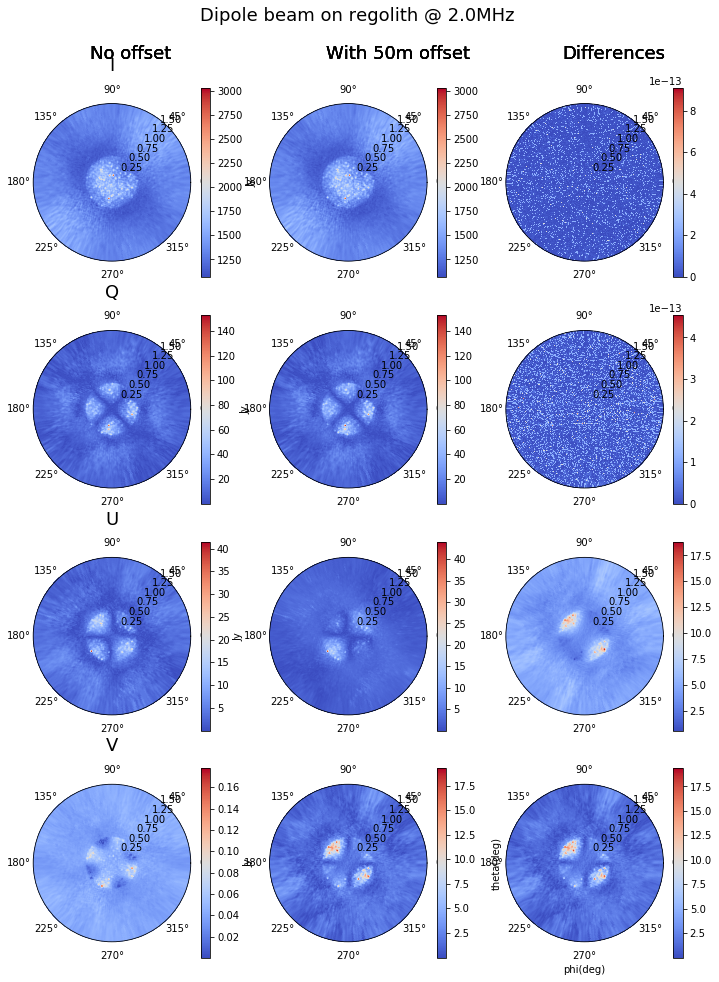

In [68]:
sky_pol = beamtopol(final)
sky_pol_off = beamtopol(final_off)

text = ['I', 'Q', 'U', 'V']
fig2,ax2 = plt.subplots(4,3, subplot_kw=dict(polar=True),figsize=(12,16))

fig2.suptitle('Dipole beam on regolith @ '+ str(f)+'MHz',fontsize=18,y=0.95)

for i in range(4):
    p2 = ax2[int(i%4),0].pcolormesh(p,t,np.abs(sky_pol[i]),cmap='coolwarm')#,norm=LogNorm())#,vmin=0, vmax = 0.0005)  
    plt.colorbar(p2, ax=ax2[int(i%4),0],label='Jy')
    #hb.Label.String = 'Jy'
    plt.ylabel('theta(deg)')
    plt.xlabel('phi(deg)')
    ax2[int(i%4),0].set_title(text[i], pad=25, fontsize = 18)
    ax2[0,0].text(1.75,2.5,'No offset', fontsize=18)
    ax2[int(i%4),0].set_rlabel_position(50)


###########################################################################################

    p2 = ax2[int(i%4),1].pcolormesh(p,t,np.abs(sky_pol_off[i]),cmap='coolwarm')#,vmin=0, vmax = 0.0005)  
    plt.colorbar(p2, ax=ax2[int(i%4),1])
    plt.ylabel('theta(deg)')
    plt.xlabel('phi(deg)')
    ax2[0,1].text(1.75,2.5,'With 50m offset', fontsize=18)
    ax2[int(i%4),1].set_rlabel_position(50)

#########################################################################################
    p2 = ax2[int(i%4),2].pcolormesh(p,t,np.abs(sky_pol_off[i] - sky_pol[i]),cmap='coolwarm')#,vmin=0, vmax = 0.0005)  
    plt.colorbar(p2, ax=ax2[int(i%4),2])
    plt.ylabel('theta(deg)')
    plt.xlabel('phi(deg)')
    ax2[0,2].text(1.75,2.5,'Differences', fontsize=18)
    ax2[int(i%4),2].set_rlabel_position(50)




In [17]:
off_err =np.random.normal(50, 0.01, np.shape(far_array)[0])


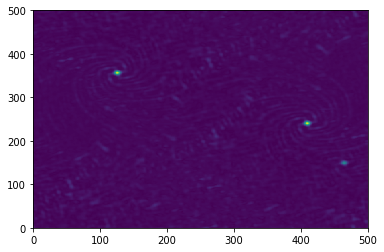

In [29]:
plt.pcolormesh(np.abs(sky_obj.image[0]))

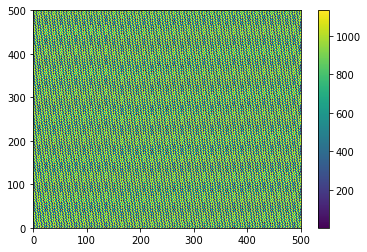

In [31]:
plt.pcolormesh(np.abs(sky_obj.beam_ft[2]));plt.colorbar()

In [45]:
sky_obj.J_b[:,:,0,0]

array([[ 1. +0.j       ,  0. +0.j       ],
       [ 0. +0.j       , -0.5+0.8660254j]])

In [23]:
sky_obj.J_in[:,:,0,0]*sky_obj.J_b[:,:,0,0]

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

TypeError: data type not understood

In [50]:
1/(-0.5+0.8660254j *  1. +0.j )

(-0.5000000032774201-0.8660254056766581j)

In [77]:
c = (fft.fftshift(fft.fft2(fft.fftshift(sky_obj.J_in[1,1]))))

In [78]:
c[0,0]

(-0.7463695143312196-9.421352586969078e-13j)

In [ ]:
fig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(5,5))
p1 =ax.pcolormesh(p,t,np.abs(sky_obj.image[0,0]),cmap='Spectral_r')#,norm=LogNorm())    #,vmin=0, vmax = 0.0005)  
plt.colorbar(p1, ax=ax)
ax.set_ylim([0,35*np.pi/180])


fig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(5,5))
p1 =ax.pcolormesh(p,t,np.abs(sky_obj.image_off[3]),cmap='Spectral_r')#,norm=LogNorm())    #,vmin=0, vmax = 0.0005)  
plt.colorbar(p1, ax=ax)
ax.set_ylim([0,35*np.pi/180])


fig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(5,5))
p1 =ax.pcolormesh(p,t,np.abs(corrected[1,1]),cmap='Spectral_r')#,norm=LogNorm())    #,vmin=0, vmax = 0.0005)  
plt.colorbar(p1, ax=ax)
ax.set_ylim([0,35*np.pi/180])

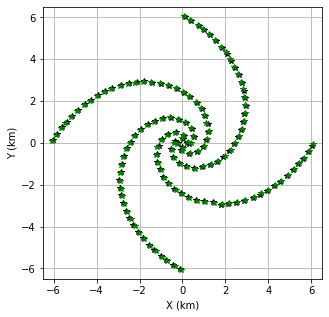

In [41]:
plt.figure(figsize=(5,5))
plt.plot(far_array[:,0],far_array[:,1],'k*')
plt.plot(far_array_off[128:,0],far_array_off[128:,1],'g*')
plt.ylabel('Y (km)')
plt.xlabel('X (km)')
plt.ylim([-6.5,6.5])
plt.xlim([-6.5,6.5])
plt.grid()
plt.savefig('Farside_layout_full.png',dpi=800)

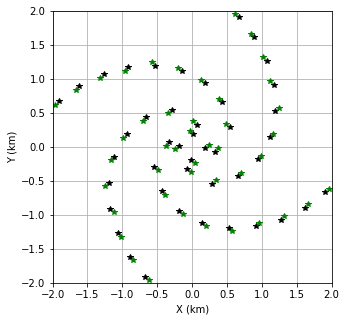

In [42]:
plt.figure(figsize=(5,5))
plt.plot(far_array[:,0],far_array[:,1],'k*')
plt.plot(far_array_off[128:,0],far_array_off[128:,1],'g*')
plt.ylabel('Y (km)')
plt.xlabel('X (km)')
plt.ylim([-2,2])
plt.xlim([-2,2])
plt.grid()
plt.savefig('Farside_layout_zoom_2by2.png',dpi=800)

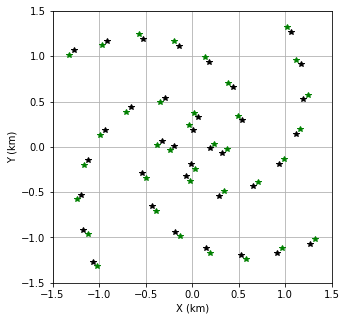

In [161]:
plt.figure(figsize=(5,5))
plt.plot(far_array[:,0],far_array[:,1],'k*')
plt.plot(far_array_off[128:,0],far_array_off[128:,1],'g*')
plt.ylabel('Y (km)')
plt.xlabel('X (km)')
plt.ylim([-1.5,1.5])
plt.xlim([-1.5,1.5])
plt.grid()
plt.savefig('Farside_layout_1p5by1p5.png',dpi=800)

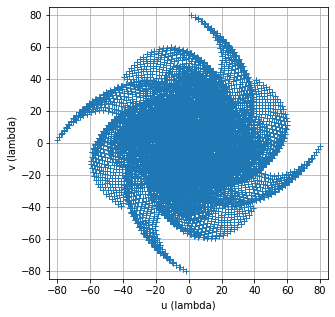

In [149]:
plt.figure(figsize=(5,5))
u,v,w = uvcal(0,0,wav,far_array)
plt.plot(u,v,'+')
plt.grid()
plt.ylabel('v (lambda)')
plt.xlabel('u (lambda)')
plt.ylim([-85,85])
plt.xlim([-85,85])
plt.savefig('/data4/nmahesh/edges/Lunar/uv-coverage_XX-YY_2MHz.png',dpi=800)

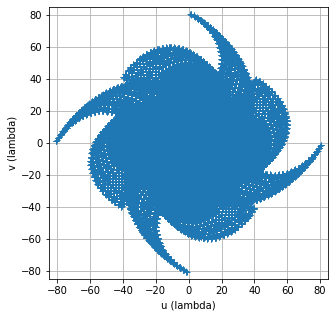

In [150]:
plt.figure(figsize=(5,5))
u,v,w = uvcal(0,0,wav,far_array_off)
plt.plot(u,v,'+')
plt.grid()
plt.ylabel('v (lambda)')
plt.xlabel('u (lambda)')
plt.ylim([-85,85])
plt.xlim([-85,85])
plt.savefig('/data4/nmahesh/edges/Lunar/uv-coverage_XY_2MHz.png',dpi=800)

Text(0.5, 0, 'u (lambda)')

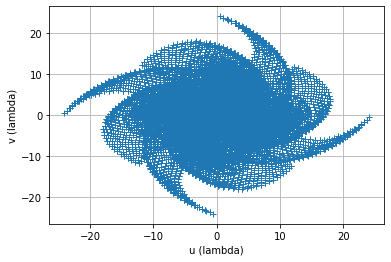

In [146]:
u,v,w = uvcal(0,0,500,far_array)
plt.plot(u,v,'+')
plt.grid()
plt.ylabel('v (lambda)')
plt.xlabel('u (lambda)')